In [1]:
import os
import warnings
import torch
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
from process import utils
from process.utils import normalize_sparse_matrix, sparse_mx_to_torch_sparse_tensor

plt.rcdefaults()
warnings.filterwarnings('ignore')
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

In [2]:
adata = sc.read_h5ad('D:/st_projects/data/osmFISH/osmFISH_cortex.h5ad')
adata.var_names_make_unique()
adata = adata[adata.obs['Region'] != 'Excluded'].copy()
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.scale(adata, zero_center=False, max_value=10)

In [4]:
adata.layers['counts'] = adata.X.copy()

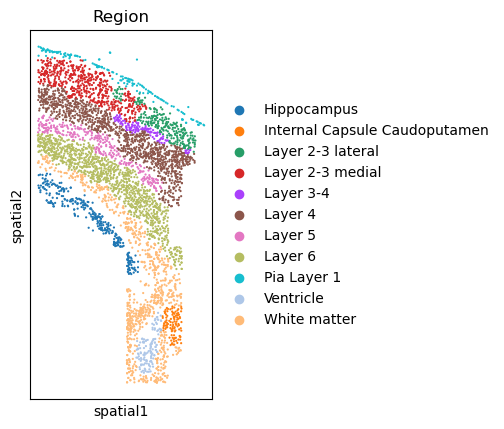

In [5]:
sc.pl.embedding(adata, basis='spatial', color=['Region'], show=False, size=10)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('figures/osmFISH_truth.pdf', dpi=600)
# plt.show()

In [9]:
signal_activity = utils.get_signal(adata, prior_file='data/kegg/gene_sets.gmt', path='data/osmFISH', threads=10)
adata.obsm['signal'] = signal_activity.loc[adata.obs_names].values
spatial_adj, graph_nei = utils.spatial_construct_graph(adata, radius=600) # 560
signal_adj = utils.features_construct_graph(adata.obsm['signal'])

Using existing signal activity file...
The graph contains 24743 undirected edges, 4839 cells.
10.2265 neighbors per cell on average.


In [12]:
features = torch.FloatTensor(adata.X)
labels = adata.obs['Region'].values

spatial_adj = normalize_sparse_matrix(spatial_adj + sp.eye(adata.shape[0]))
spatial_adj = sparse_mx_to_torch_sparse_tensor(spatial_adj)

signal_adj = normalize_sparse_matrix(signal_adj + sp.eye(adata.shape[0]))
signal_adj = sparse_mx_to_torch_sparse_tensor(signal_adj)

graph_nei_tensor = torch.LongTensor(graph_nei.numpy())

In [13]:
import random
import torch.nn as nn

def model_train(model, optimizer, features, spatial_adj, signal_adj, graph_nei, alpha=1, beta=0.1):
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    model.train()
    optimizer.zero_grad()
    embd, rec_adj, pi, disp, mean, att = model(features, spatial_adj, signal_adj)

    # structure loss
    n = graph_nei.size(0)
    diag_mask = torch.eye(n, dtype=torch.bool, device=graph_nei.device)
    mask = ~diag_mask
    num_pos = graph_nei[mask].sum()
    num_all = mask.sum()
    num_neg = num_all - num_pos
    pos_weight = (num_neg / (num_pos + 1e-8)).clamp(max=100.).to(rec_adj.device)
    crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')
    loss_mat = crit(rec_adj, graph_nei.float())
    structure_loss = (loss_mat[mask]).mean()   # 仅对 off-diagonal 求均值

    zinb_loss = SiDMGF.ZINB(pi, theta=disp, ridge_lambda=0).loss(features, mean, mean=True)
    total_loss = alpha * zinb_loss + beta * structure_loss
    total_loss.backward()
    optimizer.step()

    return embd, att, total_loss.item(), pi, disp, mean, att

In [14]:
from tqdm import tqdm
from model import SiDMGF
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features, spatial_adj, signal_adj = features.to(device), spatial_adj.to(device), signal_adj.to(device)
graph_nei = graph_nei.to(device)

model = SiDMGF.SiDMGF(nfeat=features.shape[1], nhid1=128, nhid2=64, dropout=0.1).to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001, weight_decay=5e-4)

ari_max = 0
best_emd = None
best_cluster = None
best_mean = None

for epoch in tqdm(range(1, 501), leave=True, desc="Training epochs"):
    model.train()
    optimizer.zero_grad()
    embd, att, loss, pi, disp, mean, att = model_train(model, optimizer, features, spatial_adj, signal_adj, graph_nei, alpha=1, beta=0.5)

    kmeans = KMeans(n_clusters=len(np.unique(labels))).fit(embd.cpu().detach().numpy())
    ari_res = adjusted_rand_score(labels, kmeans.labels_)
    if (epoch % 25 == 0) or (epoch ==1):
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, ARI: {ari_res:.4f}")

    if ari_res > ari_max:
        ari_max = ari_res
        best_emb = embd
        best_clusters = kmeans.labels_
        best_mean = mean

print(f"\n--- Training complete. ARI: {ari_max:.4f} ---")

Training epochs:   0%|          | 1/500 [00:01<09:15,  1.11s/it]

Epoch: 001, Loss: 2.2476, ARI: 0.1988


Training epochs:   5%|▌         | 25/500 [00:06<01:47,  4.44it/s]

Epoch: 025, Loss: 1.6162, ARI: 0.3600


Training epochs:  10%|█         | 50/500 [00:12<01:43,  4.36it/s]

Epoch: 050, Loss: 1.4414, ARI: 0.5344


Training epochs:  15%|█▌        | 75/500 [00:17<01:35,  4.47it/s]

Epoch: 075, Loss: 1.3871, ARI: 0.5783


Training epochs:  20%|██        | 100/500 [00:23<01:29,  4.46it/s]

Epoch: 100, Loss: 1.3561, ARI: 0.6471


Training epochs:  25%|██▌       | 125/500 [00:29<01:23,  4.47it/s]

Epoch: 125, Loss: 1.3413, ARI: 0.6427


Training epochs:  30%|███       | 151/500 [00:34<01:16,  4.53it/s]

Epoch: 150, Loss: 1.3312, ARI: 0.6716


Training epochs:  35%|███▌      | 175/500 [00:40<01:13,  4.44it/s]

Epoch: 175, Loss: 1.3241, ARI: 0.6341


Training epochs:  40%|████      | 200/500 [00:45<01:05,  4.56it/s]

Epoch: 200, Loss: 1.3188, ARI: 0.6314


Training epochs:  45%|████▌     | 225/500 [00:51<01:04,  4.24it/s]

Epoch: 225, Loss: 1.3194, ARI: 0.6233


Training epochs:  50%|█████     | 251/500 [00:57<00:53,  4.62it/s]

Epoch: 250, Loss: 1.3139, ARI: 0.6355


Training epochs:  55%|█████▌    | 275/500 [01:02<00:49,  4.56it/s]

Epoch: 275, Loss: 1.3100, ARI: 0.6424


Training epochs:  60%|██████    | 300/500 [01:08<00:44,  4.47it/s]

Epoch: 300, Loss: 1.3089, ARI: 0.6362


Training epochs:  65%|██████▌   | 325/500 [01:13<00:39,  4.43it/s]

Epoch: 325, Loss: 1.3052, ARI: 0.6416


Training epochs:  70%|███████   | 350/500 [01:19<00:35,  4.23it/s]

Epoch: 350, Loss: 1.3043, ARI: 0.6119


Training epochs:  75%|███████▌  | 375/500 [01:25<00:27,  4.57it/s]

Epoch: 375, Loss: 1.3013, ARI: 0.6356


Training epochs:  80%|████████  | 400/500 [01:31<00:23,  4.29it/s]

Epoch: 400, Loss: 1.3017, ARI: 0.6523


Training epochs:  85%|████████▌ | 425/500 [01:36<00:17,  4.34it/s]

Epoch: 425, Loss: 1.3038, ARI: 0.6405


Training epochs:  90%|█████████ | 450/500 [01:42<00:11,  4.43it/s]

Epoch: 450, Loss: 1.2986, ARI: 0.5619


Training epochs:  95%|█████████▌| 475/500 [01:48<00:05,  4.41it/s]

Epoch: 475, Loss: 1.3012, ARI: 0.6406


Training epochs: 100%|██████████| 500/500 [01:54<00:00,  4.38it/s]

Epoch: 500, Loss: 1.2990, ARI: 0.6464

--- Training complete. ARI: 0.6795 ---


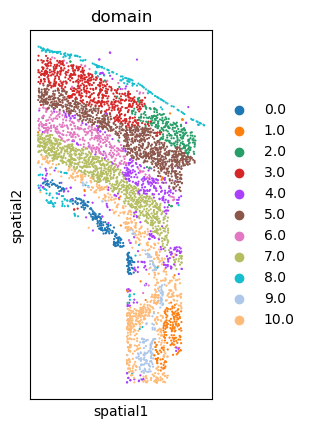

In [17]:
from process.utils import BestMap

adata.obs['domain'] = pd.Categorical(best_clusters)
adata.obs['domain'] = BestMap(pd.Categorical(adata.obs['Region']).codes, pd.Categorical(adata.obs['domain']).codes)
adata.obs['domain'] = adata.obs['domain'].astype('category')

sc.pl.embedding(adata, basis='spatial', color=['domain'], show=False, size=10)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('figures/osmFISH_SiDMGF_domain.pdf', dpi=600)
# plt.show()